### Preparation ###
Create folders and upload fp-dataset into the dataset folder.
Upload the Protein-Bert and predictor model into the models folder.

In [1]:
import torch

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(device == "cuda"):
    torch.cuda.synchronize()
print(device)

cpu


In [2]:
!mkdir models

Ein Unterverzeichnis oder eine Datei mit dem Namen "models" existiert bereits.


In [3]:
!mkdir datasets

Ein Unterverzeichnis oder eine Datei mit dem Namen "datasets" existiert bereits.


### Architecture design ###

In [4]:
pip install protein_bert_pytorch

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Prophet.DESKTOP-UUFA83J\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import torch
from protein_bert_pytorch import ProteinBERT, PretrainingWrapper
annotation_max = 1  # 2350

def proteinBERT_model():
    return ProteinBERT(
      num_tokens = 25,
      num_annotation = annotation_max,
      dim = 512,
      dim_global = 256,
      depth = 6,
      narrow_conv_kernel = 9,
      wide_conv_kernel = 9,
      wide_conv_dilation = 5,
      attn_heads = 8,
      attn_dim_head = 64,
      local_to_global_attn = False,
      local_self_attn = True,
      num_global_tokens = 2,
      glu_conv = False
  )

In [6]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def compactify_model(_model):
    _model.to_token_logits = Identity()
    _model.to_global_emb = Identity()
    _model.to_annotation_logits = Identity()
    seq = torch.randint(0, 21, (2, 250)).to(device)
    mask = torch.ones(2, 250).bool().to(device)
    annotation = torch.randint(0, 1, (2, 512)).float().to(device)
    seq_logits, annotation_logits = _model(seq, annotation, mask = mask)
    print(seq_logits.shape, annotation_logits.shape)
    return _model

In [7]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class predictorNet(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.linear1 = torch.nn.Linear(179200, 64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.linear3 = torch.nn.Linear(32, 2)
        self.dropout = torch.nn.Dropout(p=dropout)
        
    def forward(self, x, dropout=True):
        x = self.flatten(x)
        if(dropout): x = self.dropout(x)
        x = self.linear1(x)
        x = torch.nn.functional.softplus(x)
        if(dropout): x = self.dropout(x)
        x = self.linear2(x)
        x = torch.nn.functional.softplus(x)
        x = self.linear3(x)
        return x

dropout1 = 0.075
model = compactify_model(proteinBERT_model())
model.load_state_dict(torch.load('models/pretrained_drp_0075_m_ex_em_4.pt', map_location=torch.device(device)))
model_predictor = predictorNet(dropout1)
model_predictor.load_state_dict(torch.load('models/pretrained_drp_0075_b_ex_em_4.pt', map_location=torch.device(device)))

torch.Size([2, 250, 512]) torch.Size([2, 2, 256])


<All keys matched successfully>

In [8]:
model2 = compactify_model(proteinBERT_model())
model2.load_state_dict(torch.load('models/pretrained_drp_0075_m_ex_em_2A.pt', map_location=torch.device(device)))
model2_predictor = predictorNet(dropout1)
model2_predictor.load_state_dict(torch.load('models/pretrained_drp_0075_b_ex_em_2A.pt', map_location=torch.device(device)))
model3 = compactify_model(proteinBERT_model())
model3.load_state_dict(torch.load('models/pretrained_drp_0075_m_ex_em_2B.pt', map_location=torch.device(device)))
model3_predictor = predictorNet(dropout1)
model3_predictor.load_state_dict(torch.load('models/pretrained_drp_0075_b_ex_em_2B.pt', map_location=torch.device(device)))

torch.Size([2, 250, 512]) torch.Size([2, 2, 256])
torch.Size([2, 250, 512]) torch.Size([2, 2, 256])


<All keys matched successfully>

### Data preparation ###

In [9]:
def clean(result):
    if(result!=None):
        return result
    else:
        return -1

In [10]:
_acid2int = {'A' : 1,'R' : 2,'N' : 3,'D' : 4,'C' : 5,'Q' : 6,'E' : 7,'G' : 8,'H' : 9,'I' : 10,
          'L' : 11,'K' : 12,'M' : 13,'F' : 14,'P' : 15,'S' : 16,'T' : 17,'W' : 18,'Y' : 19,
          'V' : 20,'B' : 21,'Z' : 22,'X' : 23,'*' : 24,'-' : 25,'?' : 0}

def acid2int(seq : str) -> list:
    return [(_acid2int[i]) for i in seq]

x = 'ABTZX'
acid2int(x) # returns [1, 21, 17, 22, 23]

[1, 21, 17, 22, 23]

In [11]:
import json
   
# Configuration
min_seq=25
max_seq=350
    
# Opening JSON file
f = open('datasets/fp_database.json', encoding='UTF-8')
normalizer = [0.002, 0.002, 1, 0.01]

fp_dataset = []
name_list = []
# returns JSON object as 
# a dictionary
data = json.load(f)
# Iterating through the json
# list
print(len(data))
for index, i in enumerate(data):
    try:  # To read incomplete files and make this method more robust
        name=i['name']
        seq=i['seq']
        em=i['states'][0]['em_max']
        ex=i['states'][0]['ex_max']
        qy=i['states'][0]['qy']
        br=i['states'][0]['brightness']
        if(index==0):
            print(name)
            print()
            print(seq)
            print(qy)
            print(br)
            print(em)
            print(ex)
        if(seq!=None) and (em!=None) and (ex!=None): #  and (qy!=None):
            if(len(seq)>min_seq) and (len(seq)<max_seq) and (em>0) and (ex>0):
                seq_ = seq + "".join(["?"]*(max_seq-len(seq)))
                label = torch.tensor([em, ex]).float()
                sequence = torch.tensor(acid2int(seq_))
                fp_dataset.append([sequence, torch.tensor([label[0]*normalizer[0], label[1]*normalizer[1]])])
                # fp_dataset.append([sequence, torch.tensor([torch.tensor([em]).float()*normalizer[0]])])
                name_list.append(name)
    except:
        True
# Closing file
f.close()

print(len(fp_dataset))

797
617


In [12]:
import pickle
normalizer = [0.002, 0.002, 1, 0.01]
with (open("datasets/test_dataset_split_fp.pkl", "rb")) as openfile:
    [train_set, test_set] = pickle.load(openfile)  
# print(test_set[0])

In [13]:
# Get all corresponding protein names for the test-set used as the unseen reference during training process
protein_name_list = []
for protein_index, test_protein in enumerate(test_set):
    for index, element in enumerate(fp_dataset):
        if torch.all(test_protein[0].eq(element[0])):
            protein_name_list.append([protein_index, name_list[index]])
            continue
print(protein_name_list)

[[0, 'mcavRFP'], [1, 'cgfTagRFP'], [2, 'AQ14'], [3, 'rsFusionRed1'], [4, 'mRhubarb713'], [5, 'super-TagRFP'], [6, 'G1'], [7, 'Superfolder CFP'], [8, 'LanFP2'], [9, 'mEosFP-F173S'], [10, 'GFPxm18uv'], [11, 'mStable'], [12, 'mNeptune2.5'], [13, 'iRFP682'], [14, 'ShyRFP'], [15, 'deGFP1'], [16, 'mMiCy'], [17, 'sarcGFP'], [18, 'mEos4b'], [19, 'mEGFP'], [20, 'Folding Reporter GFP'], [21, 'mStrawberry'], [22, 'mCherry-XL'], [23, 'mEos2-A69T'], [24, 'mEYFP'], [25, 'Topaz'], [26, 'mNeptune2'], [27, 'd-RFP618'], [28, 'GFP(E222G)'], [29, 'h2-3'], [30, 'mGrape1'], [31, 'Skylan-NS'], [32, 'mGeos-S'], [33, 'mCherry'], [34, 'BDFP1.6'], [35, 'D10'], [36, 'RFP630'], [37, 'ptilGFP'], [38, 'eforCP'], [39, 'EBFP1.2'], [40, 'roGFP1-R8'], [41, 'scubRFP'], [42, 'mNeonGreen'], [43, 'rsFolder'], [44, 'Enhanced Cyan-Emitting GFP'], [45, 'avGFP'], [46, 'Sapphire'], [47, 'W1C'], [48, 'mRFP1-Q66S'], [49, 'mCardinal']]


In [14]:
from torch.utils.data import DataLoader
batch_size=16
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Sizes of resulting train and test-set
print(len(train_dataloader))
print(len(test_dataloader))

36
4


In [15]:
for index, element in enumerate(test_dataloader):
    print(len(element[0]))

16
16
16
2


### Predictions and Evaluation ###

In [16]:
global Epoch, lc_train, lc_test
Epoch = 0
lc_train, lc_test = [], []

In [17]:
lr_factor = 1.0

In [18]:
# do the following in a loop for a lot of sequences and annotations
from tqdm.notebook import tqdm
criterion = torch.nn.MSELoss()

# only spectra
def train_supervised(_model, _predictor, dataloader_train, dataloader_test, lr=1, epochs=10, dropout=True, dropout_flipping=False):
    dropout = dropout
    global Epoch
    optimizer = torch.optim.Adam(_model.parameters(),    lr=lr*0.0000001*lr_factor)
    optimizer2 = torch.optim.Adam(_predictor.parameters(), lr=lr*0.0000002*lr_factor)  
    summed_loss = 0.0
    for epoch in range(epochs):
        Epoch+=1
        if(Epoch%10==1):
            print("epoch: " + str(Epoch-1))
        summed_loss = 0.0
        with tqdm(total=len(dataloader_train)) as pbar:
            train_index=0
            # training process
            for index, (inputs,labels) in enumerate(dataloader_train):
                optimizer.zero_grad()
                optimizer2.zero_grad()

                annotation_list = [[0]*512]*inputs.shape[0]
                annotation = torch.tensor(annotation_list).float()
                mask       = torch.ones(inputs.shape).bool()
                
                # print(inputs.shape, annotation.shape, mask.shape)
                representation, annotation_repr = _model(inputs.to(device), annotation.to(device), mask = mask.to(device))
                if(dropout_flipping==True):
                  dropout = not dropout
                x = _predictor(representation, dropout=dropout)
                # print(labels.shape, x.shape)
                # print(inputs)
                loss = criterion(labels.to(device), x.to(device))
                summed_loss+=loss.detach()
                train_index += inputs.shape[0]
                
                loss.backward()
                optimizer.step()
                optimizer2.step()
                pbar.set_description(f'train_loss: {"%.5f" % (summed_loss/train_index*100)}')
                pbar.update(1)
            
            # evaluation process
            test_index = 0
            summed_test_loss = 0
            optimizer.zero_grad()
            optimizer2.zero_grad()   
            for _, (inputs,labels) in enumerate(dataloader_test):
                
                annotation_list = [[0]*512]*inputs.shape[0]
                annotation = torch.tensor(annotation_list).float()
                mask       = torch.ones(inputs.shape).bool()
                representation, annotation_repr = _model(inputs.to(device), annotation.to(device), mask = mask.to(device))
                x = _predictor(representation, dropout=False)
                loss = criterion(labels.to(device), x.to(device))
                test_index += inputs.shape[0]
                summed_test_loss+=loss.detach()
            
            lc_train.append(summed_loss/train_index) 
            lc_test.append(summed_test_loss/test_index)    
            pbar.set_description(f'train_loss: {"%.5f" % (summed_loss/train_index*100)}, test_loss: {"%.5f" % (summed_test_loss/test_index*100)}')
            pbar.close()


In [19]:
def print_test_instances(dataloader, model, model_predictor):
    for index, (inputs,labels) in enumerate(dataloader): 
        annotation_list = [[0]*512]*inputs.shape[0]
        annotation = torch.tensor(annotation_list).float()
        mask       = torch.ones(inputs.shape).bool()
        token, annotation_logits = model(inputs.to(device), annotation.to(device), mask = mask.to(device))
        x = model_predictor(token, dropout=False)
        loss = criterion(labels.to(device), x.to(device))
        value_list = []
        for index in range(inputs.shape[0]):
            value_list.append([round((labels[index].cpu().detach().numpy()/normalizer[0])[0],3), 
                             round((x[index].cpu().detach().numpy()/normalizer[0])[0],3)])  # :2]) # , loss)
            if(index>5):
              break
        print(value_list)
        break

print("train_data")
print_test_instances(train_dataloader, model, model_predictor)
print("test_data")
print_test_instances(test_dataloader, model, model_predictor)

train_data
[[504.0, 498.322], [502.0, 507.367], [591.0, 571.499], [480.0, 486.986], [520.0, 513.335], [538.0, 538.577], [506.0, 534.654]]
test_data
[[506.0, 469.448], [509.0, 526.012], [605.0, 603.214], [580.0, 574.099], [516.0, 511.58], [578.0, 525.968], [485.0, 532.141]]


In [20]:
# Calculate mean square error over the full test-set

def calculate_mse(dataloader, model, model_predictor, root=False):
    instance_number=0
    summed_squared_error_em=0
    summed_squared_error_ex=0
    summed_value_em=0
    summed_value_ex=0
    with tqdm(total=len(dataloader)) as pbar:
        for index, (inputs,labels) in enumerate(dataloader): 
            annotation = torch.tensor([[0]*512]*inputs.shape[0]).float()
            mask       = torch.ones(inputs.shape).bool()
            token, annotation_logits = model(inputs.to(device), annotation.to(device), mask = mask.to(device))
            x = model_predictor(token, dropout=False)
            # print(x.shape)
            for index_batch in range(x.shape[0]-1):
                instance_number+=1
                em_label=(labels[index_batch].cpu().detach().numpy()/normalizer[0])[0]
                em_output=(x[index_batch].cpu().detach().numpy()/normalizer[0])[0]
                ex_label=(labels[index_batch].cpu().detach().numpy()/normalizer[0])[1]
                ex_output=(x[index_batch].cpu().detach().numpy()/normalizer[0])[1]
                summed_squared_error_em+=(em_label-em_output)**2
                summed_squared_error_ex+=(ex_label-ex_output)**2
                summed_value_em+=em_label
                summed_value_ex+=ex_label
            mse_em=(summed_squared_error_em/instance_number)
            mse_ex=(summed_squared_error_ex/instance_number)
            m_em=(summed_value_em/instance_number)
            m_ex=(summed_value_ex/instance_number)
            pbar.set_description(f'MSE emission: {"%.3f" % mse_em}, MSE excitation: {"%.3f" % mse_ex}')
            pbar.update(1)
        return mse_em, mse_ex, m_em, m_ex

print("model1: train_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(train_dataloader, model, model_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))
print("")
print("")
print("model1: test_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(test_dataloader, model, model_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))

print("model2: train_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(train_dataloader, model2, model2_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))
print("")
print("")
print("model2: test_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(test_dataloader, model2, model2_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))

print("model3: train_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(train_dataloader, model3, model3_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))
print("")
print("")
print("model3: test_data")
mse_em, mse_ex, m_em, m_ex= calculate_mse(test_dataloader, model3, model3_predictor)
print("mean error: " + str((round(mse_em**0.5,3), round(mse_ex**0.5,3))))
print("mean values: " + str((m_em, m_ex)))

model1: train_data


  0%|          | 0/36 [00:00<?, ?it/s]

mean error: (15.694, 23.463)
mean values: (544.2975515017177, 508.41054458761846)


model1: test_data


  0%|          | 0/4 [00:00<?, ?it/s]

mean error: (29.448, 39.976)
mean values: (557.6521732496178, 521.1956515104874)
model2: train_data


  0%|          | 0/36 [00:00<?, ?it/s]

mean error: (15.909, 24.653)
mean values: (544.414312272871, 508.2636518747793)


model2: test_data


  0%|          | 0/4 [00:00<?, ?it/s]

mean error: (22.676, 36.174)
mean values: (554.5217371401579, 518.4999993365744)
model3: train_data


  0%|          | 0/36 [00:00<?, ?it/s]

mean error: (18.216, 27.369)
mean values: (543.5122407672544, 507.79660873269404)


model3: test_data


  0%|          | 0/4 [00:00<?, ?it/s]

mean error: (30.638, 42.891)
mean values: (554.4130421514096, 515.6739130434783)


### Interpretability ###

In [21]:
pip install captum

You should consider upgrading via the 'C:\Users\Prophet.DESKTOP-UUFA83J\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [22]:
import captum.attr


class combinedModel(nn.Module):
    def __init__(self, _model, _model_predictor):
        super(combinedModel, self).__init__()
        self._model = _model
        self._model_predictor = _model_predictor
        
    def forward(self, x):
        annotation_list = [[0]*512]*x.shape[0]
        annotation = torch.tensor(annotation_list).float()
        mask       = torch.ones(x.shape).bool()
        token, annotation_logits = self._model(x.to(device), annotation.to(device), mask = mask.to(device))
        x2 = self._model_predictor(token, dropout=False)
        return x2



net1 = combinedModel(model, model_predictor)
ablator1 = captum.attr.FeatureAblation(net1)

net2 = combinedModel(model2, model2_predictor)
ablator2 = captum.attr.FeatureAblation(net2)

net3 = combinedModel(model3, model3_predictor)
ablator3 = captum.attr.FeatureAblation(net3)

In [23]:
for index, (inputs,labels) in enumerate(train_dataloader): 
    instances = inputs[0:5].clone().detach()# .unsqueeze(0)
    break
    
def ablator_interpretability(_net, _ablator, _instances):
    x = _net.forward(_instances)
    attr = _ablator.attribute(_instances, show_progress=True, baselines=0)
    return attr, labels, x


print("train_data")
train_results1 = ablator_interpretability(net1, ablator1, instances)
train_results2 = ablator_interpretability(net2, ablator2, instances)
train_results3 = ablator_interpretability(net3, ablator3, instances)

train_data


Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [04:39<00:00,  1.26it/s]


### Visualization ###

[[0, 'mNeptune2'], [1, 'mCherry'], [2, 'D10'], [3, 'Sapphire'], [4, 'EBFP1.2']]


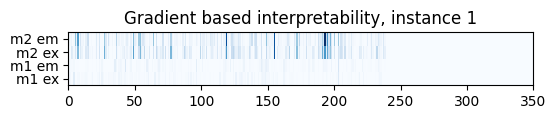

labels:[475. 433.], predictions:[474.946   426.93765]


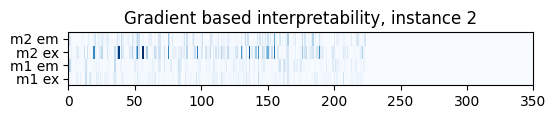

labels:[522. 503.], predictions:[526.74634 500.98227]


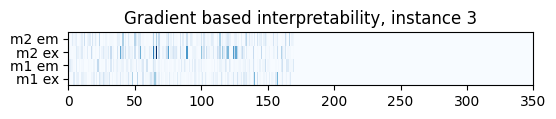

labels:[675. 375.], predictions:[638.8241 411.4286]


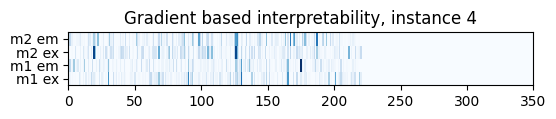

labels:[495. 468.], predictions:[505.79153 465.2231 ]


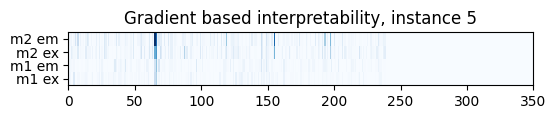

labels:[528. 515.], predictions:[522.4716  498.88446]


In [96]:
import numpy
import matplotlib
import matplotlib.pyplot as plt

def visualize_attribution(attr_list, size=5, log=True, title=""):
    sort_index = range(size)
    # uncomment to sort by emission wavelength maximum
    # sorting_values = labels[:5,0].detach().numpy()
    # s = numpy.array(sorting_values)
    # sort_index = numpy.argsort(s)
    
    # index=2
    for index in range(size):
        plot_data = []
        for model_nr in range(len(attr_list)): # bottom, top
            attribution, labels, predictions = attr_list[model_nr]
            data = attribution.detach().numpy()[index*2:(index+1)*2]
            data = data[:,:350]**2
            plot_data.append(data[0])
            plot_data.append(data[1])

        # print(attribution.shape)
        # for index in sort_index:
        default_dpi = matplotlib.rcParamsDefault['figure.dpi']
        matplotlib.rcParams['figure.dpi'] = default_dpi*1
        ax = plt.gca()
        ax.set_aspect(10)
        ax.set_yticks([0.5,1.5,2.5,3.5], minor=False)
        ax.set_yticklabels(["m1 ex","m1 em","m2 ex","m2 em"], minor=False)
        plt.pcolor(plot_data, cmap=matplotlib.cm.Blues)
        if(title == ""):
            plt.title('Gradient based interpretability, instance ' + str(index+1))
        else:
            plt.title(title)
        plt.show()
        if(log==True):
            print("labels:" + str(labels[index].detach().numpy()/normalizer[0]) + ", predictions:" + str(predictions[index].detach().numpy()/normalizer[0]))

protein_name_list = []
for protein_index, test_protein in enumerate(instances):
    for index, element in enumerate(fp_dataset):
        if torch.all(test_protein.eq(element[0])):
            protein_name_list.append([protein_index, name_list[index]])
            # continue
print(protein_name_list)

visualize_attribution([train_results3, train_results2])

In [25]:
for index, (inputs,labels) in enumerate(test_dataloader): 
    instances = inputs[0:5].clone().detach()# .unsqueeze(0)
    break
    
def ablator_interpretability(net, ablator):
    x = net.forward(instances)
    attr = ablator.attribute(instances, show_progress=True, baselines=0)
    return attr, labels, x


print("test_data")
test_results1 = ablator_interpretability(net1, ablator1)
test_results2 = ablator_interpretability(net2, ablator2)
test_results3 = ablator_interpretability(net3, ablator3)

test_data


Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [04:56<00:00,  1.18it/s]


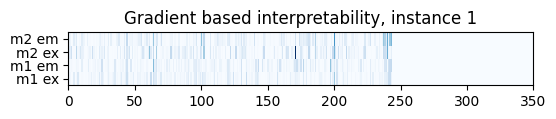

labels:[651. 599.], predictions:[645.3023 591.4455]


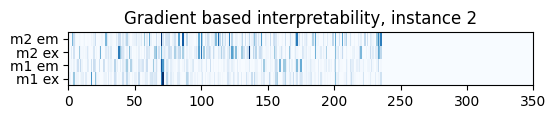

labels:[610. 587.], predictions:[603.5267 561.9971]


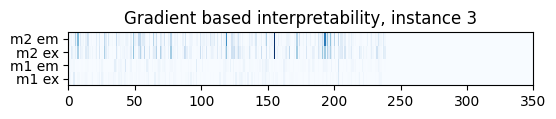

labels:[475. 433.], predictions:[479.40192 434.12912]


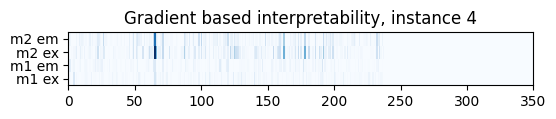

labels:[511. 399.], predictions:[502.2003  452.70816]


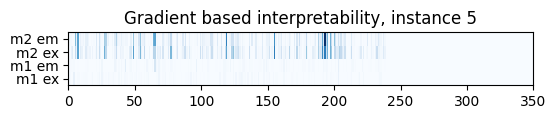

labels:[446. 379.], predictions:[444.0059  394.73935]


In [26]:
visualize_attribution([test_results3, test_results2])

### Specific protein selection by name for interpretational section of experiment ###

In [60]:
_int2acid = new_dict = dict([(value, key) for key, value in _acid2int.items()])

def int2acid(seq : int) -> list:
    return [(_int2acid[i]) for i in seq]

x = [1,21,17,22,23]
int2acid(x) # returns [1, 21, 17, 22, 23]

['A', 'B', 'T', 'Z', 'X']

In [322]:
#GFP flourophore position: residues 65–67 Ser-Tyr-Gly  ===  S-Y-G
def find_protein(name):
    for index, f_name in enumerate(name_list):
        if(name.lower() == f_name.lower()):
            seq = fp_dataset[index][0].numpy()
            CapitalSeq = int2acid(seq)
            CapitalSeq = "".join(CapitalSeq).replace("?","")
            labels = fp_dataset[index][1]/normalizer[0]
            # print(labels)
            return (index, f_name, seq, CapitalSeq, labels)

(index, f_name, seq, CapitalSeq, labels) = find_protein("avgfp")
print(index, f_name)
print(len(fp_dataset[index][0]))
print(len(CapitalSeq),CapitalSeq)
print(CapitalSeq[64:67])
print(labels)

48 avGFP
350
238 MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
SYG
tensor([509.0000, 395.0000])


In [84]:
def ablator_interpretability(_net, _ablator, _instances):
    x = _net.forward(_instances)
    attr = _ablator.attribute(_instances, show_progress=True, baselines=0)
    return attr, labels, x


print("train_data")
gfp_results1 = ablator_interpretability(net2, ablator2, torch.tensor([seq]))
gfp_results2 = ablator_interpretability(net3, ablator3, torch.tensor([seq]))

train_data


Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [01:20<00:00,  4.39it/s]


In [330]:

def visualize_attribution_with_flourophore(attr_list, title, fl_pos, m_pos=None, m_pos_name="m-pos"):
    
    plot_data = []
    plot_data.append([0]*350)
    if(m_pos != None):
        plot_data.append([0]*350)
    for model_nr in range(len(attr_list)): # bottom, top
        attribution, labels, predictions = attr_list[model_nr]
        data = attribution.detach().numpy()[0:2]
        data = data[:,:350]**2
        plot_data.append(data[0])
        plot_data.append(data[1])
        
    # Plot attributions    
    default_dpi = matplotlib.rcParamsDefault['figure.dpi']
    matplotlib.rcParams['figure.dpi'] = default_dpi*1.5
    ax = plt.gca()
    ax.set_aspect(10)
    if(m_pos != None):
        ax.set_yticks([0.5,1.5,2.5,3.5,4.5,5.5], minor=False)
        ax.set_yticklabels([m_pos_name, "f-pos","m1 ex","m1 em","m2 ex","m2 em"], minor=False)
    else:
        ax.set_yticks([0.5,1.5,2.5,3.5,4.5], minor=False)
        ax.set_yticklabels(["f-pos","m1 ex","m1 em","m2 ex","m2 em"], minor=False)        
    plt.pcolor(plot_data, cmap=matplotlib.cm.Blues)
    plt.title(title)
    
    # Show flourophore position
    fl_visualization = [0]*350
    for pos in fl_pos:
        fl_visualization[pos-1]=0.0001
    
    
    if m_pos == None:
        plt.pcolor([fl_visualization], cmap=matplotlib.cm.inferno)
    else:
        plt.pcolor([[0]*350, fl_visualization], cmap=matplotlib.cm.inferno)
        fl_visualization = [0]*350
        for pos in m_pos:
            fl_visualization[pos-1]=0.0001
        plt.pcolor([fl_visualization], cmap=matplotlib.cm.viridis)        
    plt.show()

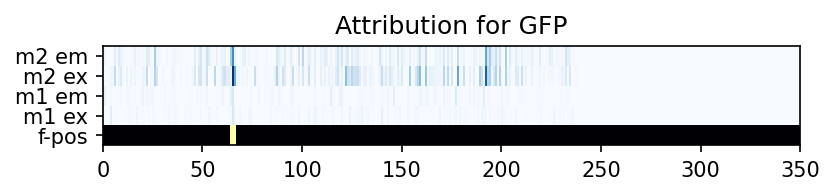

In [331]:
visualize_attribution_with_flourophore([gfp_results2, gfp_results1], title="Attribution for GFP", fl_pos=[65,66,67])

In [199]:
(index, f_name, seq, CapitalSeq, labels) = find_protein("mCerulean2.N(T65S)")
print(index, f_name)
print(len(fp_dataset[index][0]))
print(len(CapitalSeq),CapitalSeq)
print(CapitalSeq[65:68])
print(labels)

288 mCerulean2.N(T65S)
350
239 MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSWGVQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNAIHGNVYITADKQKNGIKANFGLNCNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSIQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYK
SWG
tensor([481., 439.])


In [203]:
mCerulean2_results1 = ablator_interpretability(net2, ablator2, torch.tensor([seq]))
mCerulean2_results2 = ablator_interpretability(net3, ablator3, torch.tensor([seq]))

Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [01:02<00:00,  5.62it/s]


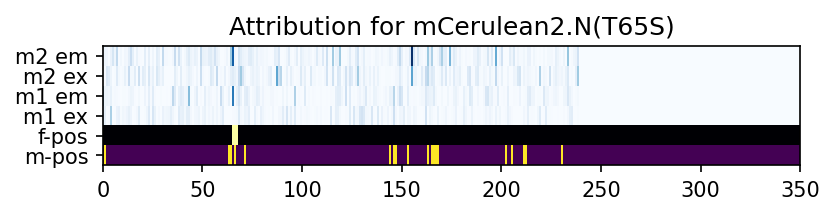

In [332]:
fl_pos=[66,67,68]
m_pos = [67,147,154,164,213,2,64,65,212,231,72,145,148,206,147,148,166,167,168,169,203,65]
title="Attribution for mCerulean2.N(T65S)"
visualize_attribution_with_flourophore([mCerulean2_results2, mCerulean2_results1], title=title, fl_pos=fl_pos, m_pos=m_pos)

In [ ]:
# Y66W; N146I, M153T, V163A, N212K; M1\_S2insV, F64L, S65T, K212N, H231L; S72A, Y145A, H148D; A206K; S147H, D148G, K166G, I167L, R168N, H169C; T203I; T65S

In [235]:
(index, f_name, seq, CapitalSeq, labels) = find_protein("eqFP611")
print(index, f_name)
print(len(fp_dataset[index][0]))
print(len(CapitalSeq),CapitalSeq)
print(CapitalSeq[62:65])
print(CapitalSeq[90-1],CapitalSeq[92-1],CapitalSeq[145-1],CapitalSeq[215-1])
print(labels)

163 eqFP611
350
231 MNSLIKENMRMMVVMEGSVNGYQFKCTGEGDGNPYMGTQTMRIKVVEGGPLPFAFDILATSFMYGSKTFIKHTKGIPDFFKQSFPEGFTWERVTRYEDGGVFTVMQDTSLEDGCLVYHAKVTGVNFPSNGAVMQKKTKGWEPNTEMLYPADGGLRGYSQMALNVDGGGYLSCSFETTYRSKKTVENFKMPGFHFVDHRLERLEESDKEMFVVQHEHAVAKFCDLPSKLGRL
MYG
W R E E
tensor([611., 559.])


In [226]:
eqFP611_results1 = ablator_interpretability(net2, ablator2, torch.tensor([seq]))
eqFP611_results2 = ablator_interpretability(net3, ablator3, torch.tensor([seq]))

Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [01:05<00:00,  5.35it/s]


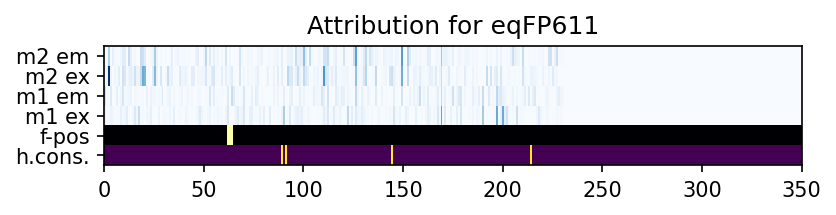

In [333]:
fl_pos=[63,64,65]
m_pos = [90,92,145,215]
title="Attribution for eqFP611"
visualize_attribution_with_flourophore([eqFP611_results2, eqFP611_results1], title=title, fl_pos=fl_pos, m_pos=m_pos, m_pos_name="h.cons.")

In [326]:
(index, f_name, seq, CapitalSeq, labels) = find_protein("mCherry")
print(index, f_name)
print(len(fp_dataset[index][0]))
print(len(CapitalSeq),CapitalSeq)
#
print(CapitalSeq[70:73])
# print(CapitalSeq[90-1+4],CapitalSeq[92-1+4],CapitalSeq[145-1+4],CapitalSeq[215-1+4])
print(labels)

293 mCherry
350
236 MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK
MYG
tensor([610., 587.])


In [327]:
mCherry_results1 = ablator_interpretability(net2, ablator2, torch.tensor([seq]))
mCherry_results2 = ablator_interpretability(net3, ablator3, torch.tensor([seq]))

Feature Ablation attribution: 100%|██████████████████████████████████████████████████| 351/351 [01:01<00:00,  5.69it/s]


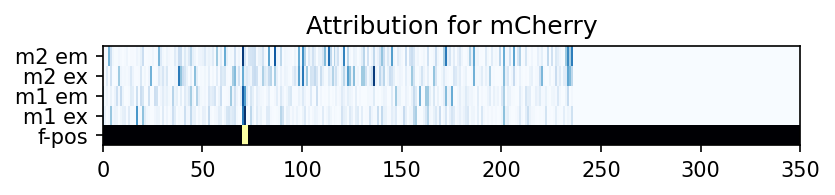

In [334]:
fl_pos=[71,72,73]
title="Attribution for mCherry"
visualize_attribution_with_flourophore([mCherry_results2, mCherry_results1], title=title, fl_pos=fl_pos)

In [321]:
#GFP flourophore position: residues 65–67 Ser-Tyr-Gly  ===  S-Y-G
def find_protein(name):
    for index, f_name in enumerate(name_list):
        if(name.lower() == f_name.lower()):
            name = name.lower()
            seq = fp_dataset[index][0].numpy()
            # print(train_set[:,0])
            for index2, train_seq in enumerate(test_set):
                # print(seq,train_seq[0].numpy())
                
                if((seq==train_seq[0].numpy()).all()):
                     return (index, index2, name, seq, CapitalSeq)
                # break
    return(0,0,0,0,0)

(index, index2, f_name, seq, seq_train) = find_protein("avgfp")
print(index, f_name)
(index, index2, f_name, seq, seq_train) = find_protein("mCerulean2.N(T65S)")
print(index, f_name)
(index, index2, f_name, seq, seq_train) = find_protein("eqFP611")
print(index, f_name)
(index, index2, f_name, seq, seq_train) = find_protein("mCherry")
print(index, f_name) # , fp_dataset[index][0], train_set[index2][0])

48 avgfp
0 0
0 0
293 mcherry
